# Query for Spectraction Results in OGA

 work with Weakly_2023_27
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/07/20
- last update : 2023/05/20

- Spectractor https://github.com/lsst/Spectractor/
- Spectractor Version 2.5



In [1]:
! eups list -s | grep LOCAL

atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2023_27/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/eups 	setup


In [2]:
! eups list -s lsst_distrib

   gdf42428520+4e9f6d16c8 	current w_2023_27 setup


In [3]:
import h5py

In [4]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [6]:
import pickle

In [7]:
from astropy.time import Time
import astropy.units as u

## Config

In [8]:
FLAG_MOUNT_ERRORS= False

### Butler

In [9]:
#repo =  "/sdf/group/rubin/repo/main"
#repo = "/sdf/group/rubin/repo/oga/"
repo = "/repo/embargo/"
butler = dafButler.Butler(repo)
registry = butler.registry

### Date & Filter & Disperser & collection

- make your choice

In [10]:
MODE_REBIN = 2

# with rebin=2
nohup bps submit survey_singleframe_v84.yaml > bps_manyspectra_v84.out &
nohup bps submit survey_singleframe_v85.yaml > bps_manyspectra_v85.out &
nohup bps submit survey_singleframe_v86.yaml > bps_manyspectra_v86.out &

# with rebin=1
nohup bps submit survey_singleframe_v87.yaml > bps_manyspectra_v87.out &
nohup bps submit survey_singleframe_v88.yaml > bps_manyspectra_v88.out &
nohup bps submit survey_singleframe_v89.yaml > bps_manyspectra_v89.out &

# May 09,10,11

# with rebin=2
nohup bps submit survey_singleframe_v90.yaml > bps_manyspectra_v90.out &
nohup bps submit survey_singleframe_v91.yaml > bps_manyspectra_v91.out &
nohup bps submit survey_singleframe_v92.yaml > bps_manyspectra_v92.out &



# with rebin=1
nohup bps submit survey_singleframe_v93.yaml > bps_manyspectra_v93.out &
nohup bps submit survey_singleframe_v94.yaml > bps_manyspectra_v94.out &
nohup bps submit survey_singleframe_v95.yaml > bps_manyspectra_v95.out &


#July 18th

#with rebin=2
nohup bps submit survey_singleframe_v96.yaml > bps_manyspectra_v96.out &

#with rebin=1
nohup bps submit survey_singleframe_v97.yaml > bps_manyspectra_v97.out &

In [11]:
DateToRuncollection_rebin2 = {
 # July 2023
 20230718 :  "u/dagoret/BPS_manyspectro_v96", # Missing collection
}
DateToRuncollection_rebin1 = {
 # July 2023
 20230718 :  "u/dagoret/BPS_manyspectro_v97", # Missing collection
}

In [12]:
DATE = 20230718

if MODE_REBIN == 2:
    my_collection = DateToRuncollection_rebin2[DATE]
else:
    my_collection = DateToRuncollection_rebin1[DATE]

filterdispersername = "empty~holo4_003"

RUNSELECTION = 20230330
#RUNSELECTION = 20230403

# List of Dataset types avalaible in my collection

## List of dataset types

In [13]:
list(registry.queryDatasetTypes("*spec*"))

[DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict),
 DatasetType('spectraction', {band, instrument, detector, physical_filter, visit}, Spectraction),
 DatasetType('spectractorImage', {band, instrument, detector, physical_filter, visit}, SpectractorImage),
 DatasetType('spectractorSpectrum', {band, instrument, detector, physical_filter, visit}, SpectractorSpectrum),
 DatasetType('spectrogramLibradtranFitParameters', {band, instrument, detector, physical_filter, visit}, SpectractorFitParameters),
 DatasetType('spectrumForwardModelFitParameters', {band, instrument, detector, physical_filter, visit}, SpectractorFitParameters),
 DatasetType('spectrumLibradtranFitParameters', {band, instrument, detector, physical_filter, visit}, SpectractorFitParameters)]

## list of datasets

In [14]:
list(registry.queryDatasets("*spec*", collections=[my_collection]))[:10]

[DatasetRef(DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict), {instrument: 'LATISS', detector: 0, visit: 2023071800374, ...}, run='u/dagoret/BPS_manyspectro_v96/20230720T135056Z', id=750f6f1c-52dc-48cd-b952-3bdcff7b078e),
 DatasetRef(DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict), {instrument: 'LATISS', detector: 0, visit: 2023071800369, ...}, run='u/dagoret/BPS_manyspectro_v96/20230720T135056Z', id=7a708382-84fa-4607-9f7a-075e0e7e3c0f),
 DatasetRef(DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict), {instrument: 'LATISS', detector: 0, visit: 2023071800368, ...}, run='u/dagoret/BPS_manyspectro_v96/20230720T135056Z', id=9c3bddb1-2452-40f9-aa65-00ce5aa951f4),
 DatasetRef(DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict), {instrument: 'LATISS', detector: 0, visit: 2

In [71]:
print(butler.registry.dimensions["exposure"].RecordClass.fields)

exposure: 
  instrument: str
  id: int
  physical_filter: str
  obs_id: str
  exposure_time: float
  dark_time: float
  observation_type: str
  observation_reason: str
  day_obs: int
  seq_num: int
  seq_start: int
  seq_end: int
  group_name: str
  group_id: int
  target_name: str
  science_program: str
  tracking_ra: float
  tracking_dec: float
  sky_angle: float
  azimuth: float
  zenith_angle: float
  has_simulated: bool
  timespan: lsst.daf.butler.Timespan


In [85]:
where_clause = f"instrument=\'LATISS\' AND exposure.day_obs={DATE} AND exposure.science_program=\'spec\'"

In [86]:
where_clause

"instrument='LATISS' AND exposure.day_obs=20230718 AND exposure.science_program='spec'"

In [87]:
results_exposures = registry.queryDimensionRecords('exposure',datasets="raw",collections = 'LATISS/raw/all',where=where_clause)

In [88]:
#results_exposures = registry.queryDimensionRecords('exposure',datasets="raw",collections = 'LATISS/raw/all',where= "instrument='LATISS' AND exposure.day_obs=20230718 AND exposure.science_program='spec'")

In [96]:
list_exposures_attrib = list(results_exposures)
dict_exposure = {}
for element in list_exposures_attrib:
    element_id = element.id
    print(f'--------- {element_id} -------')
    print(element.toDict())
    dict_exposure[element_id] = element.toDict()

--------- 2023071800368 -------
{'instrument': 'LATISS', 'id': 2023071800368, 'physical_filter': 'empty~holo4_003', 'obs_id': 'AT_O_20230718_000368', 'exposure_time': 30.0, 'dark_time': 30.2356, 'observation_type': 'science', 'observation_reason': 'generic', 'day_obs': 20230718, 'seq_num': 368, 'seq_start': 368, 'seq_end': 368, 'group_name': '2023-07-19T03:04:38.668', 'group_id': 2696654786680000, 'target_name': 'HD 192814', 'science_program': 'spec', 'tracking_ra': 304.4354761930177, 'tracking_dec': -25.969373429678743, 'sky_angle': 1.3589336141889217, 'azimuth': 88.94580481601834, 'zenith_angle': 28.11626807558241, 'has_simulated': False, 'timespan': Timespan(begin=astropy.time.Time('2023-07-19 03:09:48.085002', scale='tai', format='iso'), end=astropy.time.Time('2023-07-19 03:10:18.321000', scale='tai', format='iso'))}
--------- 2023071800369 -------
{'instrument': 'LATISS', 'id': 2023071800369, 'physical_filter': 'empty~holo4_003', 'obs_id': 'AT_O_20230718_000369', 'exposure_time': 

In [98]:
#dict_exposure

### Spectractor

In [15]:
if MODE_REBIN == 2:
    configmode = "PSF2DFFM_REBIN2"
else:
    configmode = "PSF2DFFM_REBIN1"

specver="specV2.5"

https://www.pythonforthelab.com/blog/how-to-use-hdf5-files-in-python/

In [16]:
#summary_file = f"summaryspectra_{DATE}-{filterdispersername}-{configmode}-oga.csv"
summary_file = f"summaryspectra_{DATE}-{filterdispersername}-{configmode}-{specver}-oga.csv"
output_file_h5 = f"allspectra_{DATE}-{filterdispersername}-{configmode}-{specver}-oga.hdf5"

### The collection

In [17]:
datasetRefs = registry.queryDatasets(datasetType='spectractorSpectrum', collections=my_collection, where= "instrument='LATISS'")

In [18]:
# following line not possible in OGA
#butler = butlerUtils.makeDefaultLatissButler(extraCollections=[my_collection])

In [19]:
if FLAG_MOUNT_ERRORS:
    df_mounterrors = pd.read_csv("mountErrors.csv")
    df=df_mounterrors[df_mounterrors["date_obs"] == DATE ]
    if len(df) == 0:
        FLAG_MOUNT_ERRORS = False
        

## Loop on exposures

In [20]:
#outfile.close()

In [99]:
all_dataId = []     # full data id
all_spec = []       # spectra
all_exposures = []  # exposure number
all_num = []        # sequence numbers
all_h5group = []

hf_outfile =  h5py.File(output_file_h5, 'w') 
  

for i, ref in enumerate(datasetRefs):

    print(f"============= ({i}) ============datasetType = spectraction ============================================")
    print("fullId..................:",ref.dataId.full)
    print("visit...................:",ref.dataId["visit"])
    print("band....................:",ref.dataId["band"])
    print("physical filter.........:",ref.dataId["physical_filter"])
    print("run.....................:",ref.run)
    
    #through old runs
    date_of_run = int(ref.run.split("/")[-1].split("T")[0])
    
 
    
    
    the_exposure = ref.dataId["visit"]
    the_day_obs = ref.dataId["visit"]//100_000
    the_seq_num = ref.dataId["visit"]- the_day_obs*100_000    
    the_dataId = {'day_obs': the_day_obs,'seq_num':the_seq_num,'detector':0}
    print(the_dataId)
    
    
    print(dict_exposure[the_exposure])
    
    the_exposure_key = str(the_exposure)
    
    if the_exposure not in all_exposures:
        g = hf_outfile.create_group(the_exposure_key)
        all_h5group.append(g) 
    else:
        print(f">>>>>>  already existing key {the_exposure_key} Skip it !!! ")
        the_exposure_key = the_exposure_key + "_b"
        continue
   
    
    # retrieve the spectrum from Butler
    #spec       = butler.get('spectraction',the_dataId)
    spec = butler.get('spectractorSpectrum', visit=the_exposure, detector=0, collections=my_collection, instrument='LATISS')
    
    # save in collection lists
    all_dataId.append(the_dataId) 
    all_exposures.append(the_exposure)
    all_spec.append(spec)
    all_num.append(the_seq_num)
    

============= (0) ============datasetType = spectraction ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_003', visit: 2023071800373}
visit...................: 2023071800373
band....................: white
physical filter.........: empty~holo4_003
run.....................: u/dagoret/BPS_manyspectro_v96/20230720T135056Z
{'day_obs': 20230718, 'seq_num': 373, 'detector': 0}
{'instrument': 'LATISS', 'id': 2023071800373, 'physical_filter': 'empty~holo4_003', 'obs_id': 'AT_O_20230718_000373', 'exposure_time': 30.0, 'dark_time': 30.2361, 'observation_type': 'science', 'observation_reason': 'generic', 'day_obs': 20230718, 'seq_num': 373, 'seq_start': 373, 'seq_end': 373, 'group_name': '2023-07-19T03:13:27.937', 'group_id': 2696660079370000, 'target_name': 'HD146233', 'science_program': 'spec', 'tracking_ra': 243.8757452562806, 'tracking_dec': -8.40351662477921, 'sky_angle': 216.8603546274553,

In [22]:
hf_outfile.keys()

<KeysViewHDF5 ['2023071800368', '2023071800369', '2023071800373', '2023071800374']>

In [23]:
index = 0

spec = all_spec[index]

In [24]:
the_h5group = all_h5group[index] 

In [25]:
d = the_h5group.create_dataset('airmass', data=spec.airmass)

In [26]:
spec.airmass

1.23317103363995

In [27]:
spec.date_obs

'2023-07-19T03:15:44.023000135Z'

In [28]:
spec.cov_matrix.shape

(1136, 1136)

In [29]:
spec.lambdas.shape

(1136,)

In [30]:
spec.data_next_order.shape

(1136,)

In [31]:
#spec.chromatic_psf.load_table()
spec.chromatic_psf.table

lambdas,Dx,Dy,Dy_disp_axis,flux_sum,flux_integral,flux_err,fwhm,Dy_fwhm_sup,Dy_fwhm_inf,amplitude,x_c,y_c,gamma,alpha,saturation
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
297.4768966212818,418.3908746751692,0.8226297959892861,1.4604735725479576,5.058766739861795,1.0,7.6609240462402095,6.633644519444843,1.2753640455349746,-6.1860778068750735,1.0,-0.006548880794298384,15.98666895121508,6.468929149344975,2.970325798173052,22666.666666666675
298.1883030270395,419.3908746751692,0.8257350815562319,1.4639642642659618,2.0766128906739088,1.0,7.653848290600986,6.629871600132148,1.2871615575253663,-6.169001080297888,1.0,0.9935644466168014,16.01970775462142,6.46466730173127,2.9705360985308933,22666.666666666675
298.8996866305313,420.3908746751692,0.8288353185295279,1.4674549559839658,14.684019728549423,1.0,7.677755621394341,6.6238200754031595,1.2989448192601023,-6.151938603976361,1.0,1.993676797532487,16.05253088026717,6.460405745581101,2.970742925603673,22666.666666666675
299.61104755766934,421.3908746751692,0.8319305069091456,1.47094564770197,21.23389168893347,1.0,7.676750374341757,6.619708651104702,1.3107138307391537,-6.1348903779105175,1.0,2.993788183533411,16.085140791635155,6.456144480894466,2.9709462793913906,22666.666666666675
300.322385932062,422.3908746751692,0.8350206466950993,1.4744363394199742,-4.6042781681528595,1.0,7.641006025858292,6.614383061933552,1.3224685919625345,-6.117856402100344,1.0,3.9938986160201466,16.117539914345727,6.451883507671367,2.9711461598940465,22666.666666666675
301.0337018750703,423.3908746751692,0.8381057378873891,1.4779270311379784,13.909187388592251,1.0,7.639456434033027,6.609938139931444,1.3342091029302454,-6.100836676545842,1.0,4.994008106218814,16.14973063706553,6.447622825911802,2.9713425671116407,22666.666666666675
301.74499550583306,424.3908746751692,0.8411857804860006,1.4814177228559828,11.709734402465859,1.0,7.581486401261667,6.606735391744763,1.3456556517013605,-6.083551489306083,1.0,5.994116665182332,16.181715311940124,6.443362435615773,2.971535501044173,22666.666666666675
302.45626694133335,425.3908746751692,0.8442607744909623,1.484908414573987,15.147116131879745,1.0,7.614601945878082,6.599814129273426,1.3570879502168052,-6.066280552321996,1.0,6.994224303795306,16.213496255675793,6.439102336783279,2.971724961691644,22666.666666666675
303.1675162964303,426.3908746751692,0.8473307199022315,1.4883991062919915,3.5883607743960866,1.0,7.600571458359446,6.596982288944844,1.3685059984765797,-6.049023865593577,1.0,7.994331032777325,16.24507575005883,6.43484252941432,2.971910949054053,22666.666666666675


In [32]:
spec.spectrogram_saturation

22666.66666666667

In [33]:
spec.chromatic_psf.plot_summary()

In [34]:
def DumpSpectrum(spec):
    print("--------------------------------------------")
    print("spec.target.label\t",spec.target.label)
    print("spec.filter_label\t",spec.filter_label)
    print("spec.airmass\t",spec.airmass)
    print("spec.date_obs\t",spec.date_obs)
    print("spec.temperature\t",spec.temperature)
    print("spec.pressure\t",spec.pressure)
    print("spec.humidity\t",spec.humidity)    
    #print("spec.ra\t",spec.ra)
    print("spec.dec\t",spec.dec)
    print("spec.hour_angle\t",spec.hour_angle)
    print("spec.parallactic_angle\t",spec.parallactic_angle)
    print("spec.camera_angle\t", spec.camera_angle)
    print("--------------------------------------------")
    print("spec.order\t",spec.order)
    print("spec.lambdas\t",spec.lambdas)
    print("spec.data\t",spec.data)
    print("spec.err\t",spec.err)
    print("spec.covmatrix\t",spec.cov_matrix)
    print("--------------------------------------------")
    print("spec.data_next_order\t",spec.data_next_order)
    print("spec.err_next_order\t",spec.err_next_order)

In [35]:
def AddDataSetsInGroup(spec,h5group):
  
   
    #spectrum

    h5group.attrs['spec_target_label'] = spec.target.label
    h5group.attrs['spec_filter_label'] = spec.filter_label
    h5group.attrs["spec_date_obs"] = spec.date_obs
    h5group.attrs["spec_airmass"] = spec.airmass 
    h5group.attrs["spec_temperature"] = spec.temperature
    h5group.attrs["spec_pressure"] = spec.pressure
    h5group.attrs["spec_humidity"] = spec.humidity
    h5group.attrs["spec_dec"] = spec.dec
    h5group.attrs["spec_hour_angle"] = spec.hour_angle
    h5group.attrs["spec_parallactic_angle"] = spec.parallactic_angle
    h5group.attrs["spec_camera_angle"] = spec.camera_angle
    h5group.attrs["spec_order"] = spec.order
    
    
    d = h5group.create_dataset("spec_lambdas",data=spec.lambdas,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_data",data=spec.data,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_err",data=spec.err,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_covmatrix",data=spec.cov_matrix,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_data_next_order",data=spec.data_next_order,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_err_next_order",data=spec.err_next_order,compression="gzip", compression_opts=9)
    
    # spectrogram
    
    d = h5group.create_dataset("spec_spectrogram",data=spec.spectrogram,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_spectrogram_bgd",data=spec.spectrogram_bgd,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_spectrogram_bgd_rms",data=spec.spectrogram_bgd_rms,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_spectrogram_err",data=spec.spectrogram_err,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_spectrogram_residuals",data=spec.spectrogram_residuals,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_spectrogram_fit",data=spec.spectrogram_fit,compression="gzip", compression_opts=9)
    
    
    h5group.attrs["spec_spectrogram_x0"]=spec.spectrogram_x0
    h5group.attrs["spec_spectrogram_y0"]=spec.spectrogram_y0
    h5group.attrs["spec_spectrogram_xmin"]=spec.spectrogram_xmin
    h5group.attrs["spec_spectrogram_xmax"]=spec.spectrogram_xmax
    h5group.attrs["spec_spectrogram_ymin"]=spec.spectrogram_ymin
    h5group.attrs["spec_spectrogram_ymax"]=spec.spectrogram_ymax
    h5group.attrs["spec_spectrogram_deg"]=spec.spectrogram_deg
    h5group.attrs["spec_spectrogram_saturation"]=spec.spectrogram_saturation      
    h5group.attrs["spec_spectrogram_Nx"]=spec.spectrogram_Nx
    h5group.attrs["spec_spectrogram_Ny"]=spec.spectrogram_Ny
    
    
    # header
    
    h5group.attrs["spec_header_target"]=spec.header["TARGET"]
    h5group.attrs["spec_header_redshift"]=spec.header["REDSHIFT"]
    h5group.attrs['spec_header_grating']=spec.header["GRATING"]
    h5group.attrs["spec_header_rotangle"]=spec.header["ROTANGLE"]
    h5group.attrs["spec_header_d2ccd"]=spec.header["D2CCD"]
    h5group.attrs["spec_header_lshift"]=spec.header["LSHIFT"]
    h5group.attrs["spec_header_parangle"]=spec.header["PARANGLE"]
    h5group.attrs["spec_header_targetx"]=spec.header["TARGETX"]
    h5group.attrs["spec_header_targety"]=spec.header["TARGETY"]
    h5group.attrs["spec_header_lbda_ref"]=spec.header["LBDA_REF"]
    h5group.attrs["spec_header_pixshift"]=spec.header["PIXSHIFT"]
    h5group.attrs["spec_header_psf_reg"]=spec.header["PSF_REG"]
    h5group.attrs["spec_header_trace_r"]=spec.header["TRACE_R"]   
    h5group.attrs["spec_header_chi2_fit"]=spec.header["CHI2_FIT"]   
    h5group.attrs["spec_header_a2_fit"]=spec.header["A2_FIT"]
    h5group.attrs["spec_header_am_fit"]=spec.header["AM_FIT"]
    h5group.attrs["spec_header_meanfwhm"]=spec.header["MEANFWHM"]
    h5group.attrs["spec_header_version"]=spec.header["VERSION"]
    h5group.attrs["spec_header_rebin"]=spec.header["REBIN"]
    h5group.attrs['spec_header_date-obs']=spec.header["DATE-OBS"]
    h5group.attrs["spec_header_exptime"]=spec.header["EXPTIME"]
    h5group.attrs["spec_header_airmass"]=spec.header["AIRMASS"] 
    h5group.attrs["spec_header_dec"]=spec.header["DEC"]
    h5group.attrs["spec_header_ha"]=spec.header["HA"]
    h5group.attrs["spec_header_outtemp"]=spec.header["OUTTEMP"] 
    h5group.attrs["spec_header_outpress"]=spec.header["OUTPRESS"] 
    h5group.attrs["spec_header_outhum"]=spec.header["OUTHUM"]
    h5group.attrs["spec_header_filter"]=spec.header["FILTER"]
    h5group.attrs["spec_header_cam_rot"]=spec.header["CAM_ROT"] 
    h5group.attrs["spec_header_s_x0"]=spec.header["S_X0"]
    h5group.attrs["spec_header_s_y0"]=spec.header["S_Y0"]
    h5group.attrs["spec_header_s_xmin"]=spec.header["S_XMIN"]      
    h5group.attrs["spec_header_s_xmax"]=spec.header["S_XMAX"]                                               
    h5group.attrs["spec_header_s_ymin"]=spec.header["S_YMIN"]      
    h5group.attrs["spec_header_s_ymax"]=spec.header["S_YMAX"]                                                                                                                  
    h5group.attrs["spec_header_s_nx"]=spec.header["S_NX"]
    h5group.attrs["spec_header_s_ny"]=spec.header["S_NY"]   
    h5group.attrs["spec_header_s_dec"]=spec.header["S_DEG"]  
    h5group.attrs["spec_header_s_sat"]=spec.header["S_SAT"]      
                                               
    

In [36]:
def AddMountErrorsInGroup(h5group,az_rms,el_rms,rot_rms,image_az_rms,image_el_rms,image_rot_rms):
    h5group.attrs["me_az_rms"]=az_rms
    h5group.attrs["me_el_rms"]=el_rms
    h5group.attrs["me_rot_rms"]=rot_rms
    h5group.attrs["me_image_az_rms"]=image_az_rms
    h5group.attrs["me_image_el_rms"]=image_el_rms
    h5group.attrs["me_image_rot_rms"]=image_rot_rms
        

In [37]:
def AddDataSetsInGroupAndIndexExposure(spec,h5group,index,exposure):

    h5group.attrs["index"]=index
    h5group.attrs["exposure"]=exposure
    
    AddDataSetsInGroup(spec,h5group)

In [38]:
DumpSpectrum(spec)

--------------------------------------------
spec.target.label	 HD146233
spec.filter_label	 empty
spec.airmass	 1.23317103363995
spec.date_obs	 2023-07-19T03:15:44.023000135Z
spec.temperature	 0
spec.pressure	 0
spec.humidity	 0
spec.dec	 -8.40351662477921
spec.hour_angle	 30.67736690969853
spec.parallactic_angle	 131.4821134519527
spec.camera_angle	 53.139645372545
--------------------------------------------
spec.order	 1
spec.lambdas	 [ 297.39091227  298.1023471   298.8137593  ... 1089.96498427 1090.64888978
 1091.33276005]
spec.data	 [-2.59521125e-15 -3.23739158e-15  2.92919100e-15 ...  1.14998743e-14
  1.13366091e-14  1.19843105e-14]
spec.err	 [2.06784701e-15 1.67720585e-15 1.20739447e-15 ... 1.61886056e-15
 1.81064614e-15 1.94856444e-15]
spec.covmatrix	 [[ 4.27599124e-30  3.27628713e-30  1.93695069e-30 ... -2.46152796e-42
  -2.06415224e-42 -1.86152327e-42]
 [ 3.27628713e-30  2.81301947e-30  1.79893782e-30 ... -2.35714618e-42
  -2.02177839e-42 -1.85067108e-42]
 [ 1.93695069e-30  1

# Save all spectra in a single file

In [39]:
exposures_sorted = np.sort(all_exposures)

In [40]:
for idx,spec in enumerate(all_spec):   
    the_exposure = all_exposures[idx]
    the_sorted_index = np.where(exposures_sorted == the_exposure)[0][0]
    AddDataSetsInGroupAndIndexExposure(spec,all_h5group[idx],the_sorted_index,the_exposure)
    if FLAG_MOUNT_ERRORS:
        df_exp_selected = df[df["exposure"] == the_exposure]
        N = len(df_exp_selected)
        if (N)>0:
            az_rms = df_exp_selected["az_rms"].values[0]
            el_rms = df_exp_selected["el_rms"].values[0]
            rot_rms = df_exp_selected["rot_rms"].values[0]
            image_az_rms = df_exp_selected["image_az_rms"].values[0]
            image_el_rms = df_exp_selected["image_el_rms"].values[0]
            image_rot_rms = df_exp_selected["image_rot_rms"].values[0]
            AddMountErrorsInGroup(all_h5group[idx],az_rms,el_rms,rot_rms,image_az_rms,image_el_rms,image_rot_rms)
        else:
            print(f"No error mount for exposure {the_exposure}")
            AddMountErrorsInGroup(all_h5group[idx],-1.,-1.,-1.,-1.,-1.,-1.)
            

In [41]:
hf_outfile.keys()

<KeysViewHDF5 ['2023071800368', '2023071800369', '2023071800373', '2023071800374']>

In [42]:
#AddDataSetsInGroup(spec,the_h5group) # already done previously
hf_outfile.close() 

## Plot

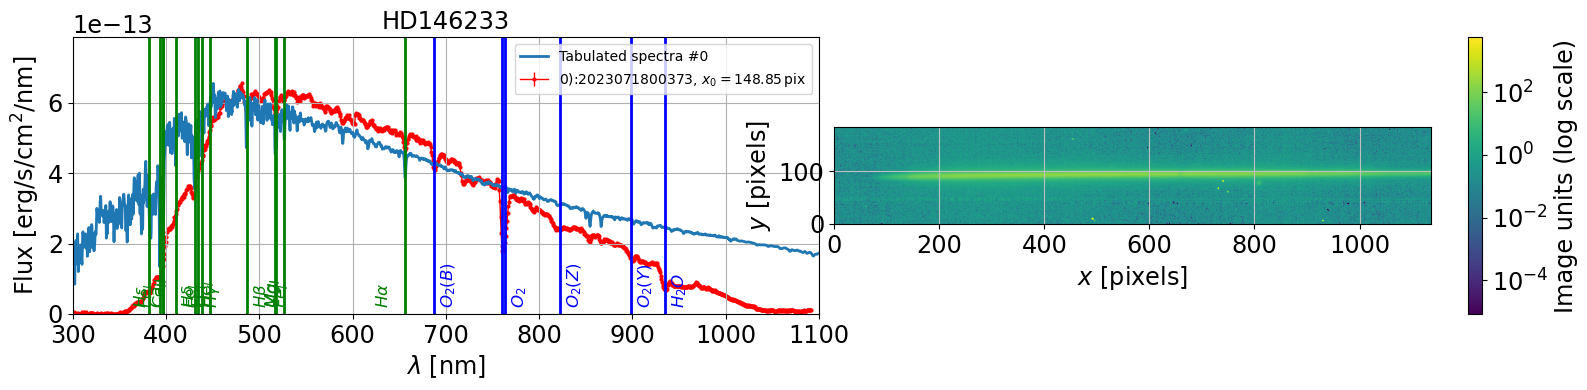

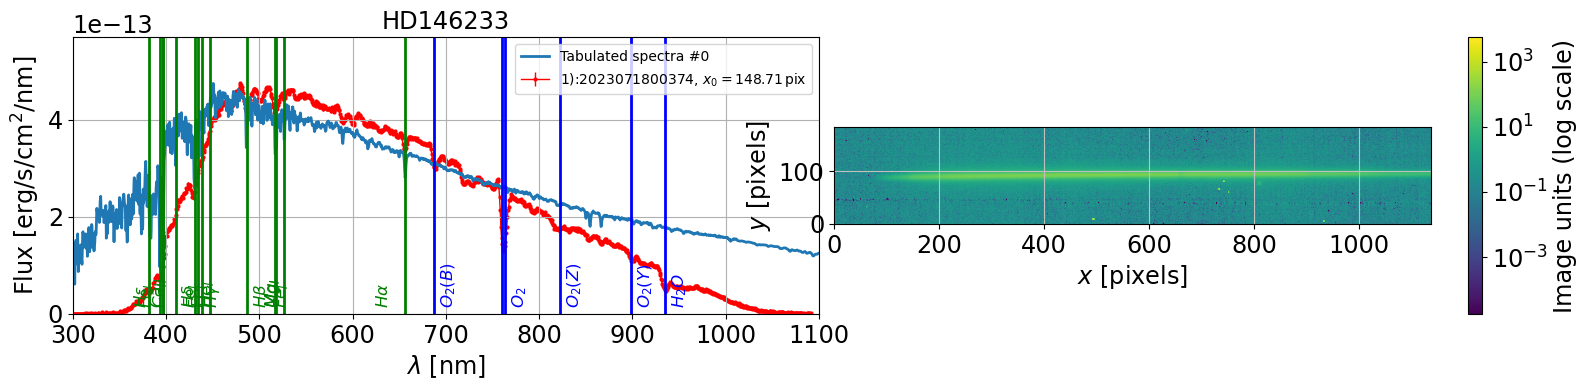

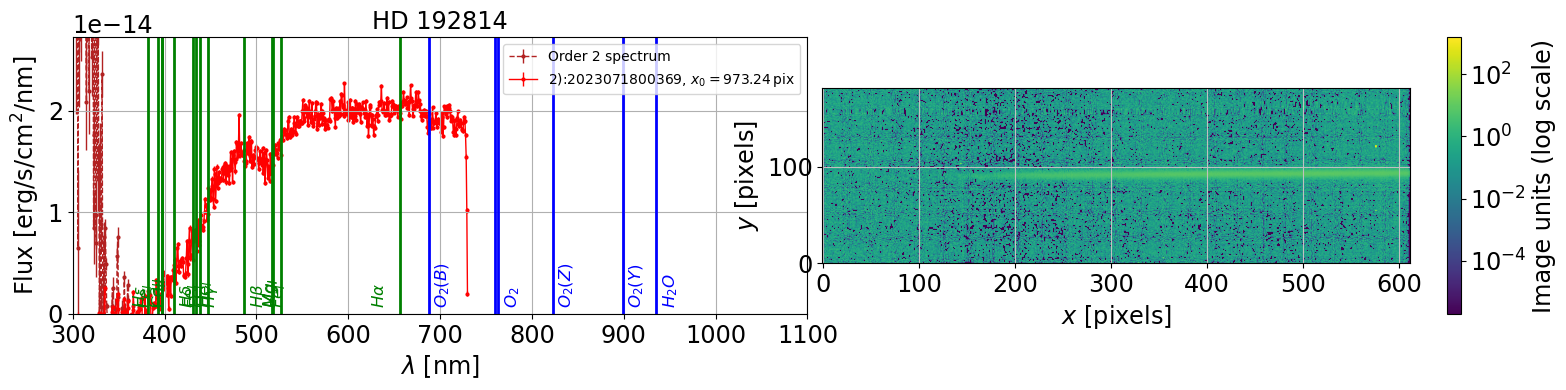

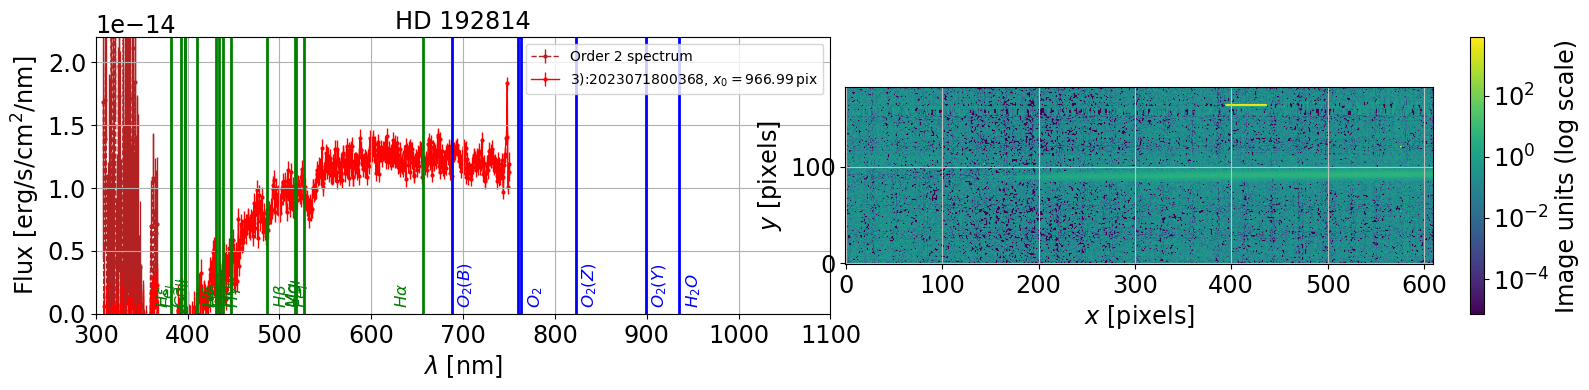

In [43]:
%matplotlib inline


infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]


idx=0
for spec in all_spec:
    
    
    #s=spec.spectrum
    s=spec
    label = str(idx) +"):" + str(all_exposures[idx])
    
    try:
        fig=plt.figure(figsize=(16,4))
    
        ax1 = fig.add_subplot(1, 2, 1)
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
        ax2 = fig.add_subplot(1, 2, 2)
        s.plot_spectrogram(ax=ax2,scale="log")
    
        all_lambdas.append(s.lambdas)
        all_data.append(s.data)
        all_data_err.append(s.err)
    
        #save info    
        infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
            
    except Exception as inst:
        print(" >>> Exception catched for "+ label )
        print(type(inst))    # the exception instance
        print(inst.args)     # arguments stored in .args

    
    idx+=1

# Generate info

In [44]:
df_infos=pd.DataFrame(infos,columns=["idx","object","date_obs","airmass","temperature","pressure","humidity"])

In [45]:
df_infos.set_index('idx',inplace=True)

In [46]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [47]:
all_reftime=np.array(all_reftime)

In [48]:
df_infos["reftime"]=all_reftime

In [49]:
NN = len(df_infos)

In [50]:
df_infos

,object,date_obs,airmass,temperature,pressure,humidity,reftime
idx,,,,,,,
0,HD146233,2023-07-19T03:15:44.023000135Z,1.233171,0,0,0,0.000000
1,HD146233,2023-07-19T03:16:26.939006370Z,1.235235,0,0,0,0.011921
2,HD 192814,2023-07-19T03:10:09.211508133Z,1.131425,0,0,0,-0.093003
3,HD 192814,2023-07-19T03:09:26.203000854Z,1.133054,0,0,0,-0.104950


### Save info file

In [51]:
df_infos.to_csv(summary_file)